Working with data
-----------------
PyTorch has two primitives to work with data:  
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.  
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 16]

PyTorch offers domain-specific libraries such as [`TorchText`](<https://pytorch.org/text/stable/index.html>),
[`TorchVision`](<https://pytorch.org/vision/stable/index.html>), and [`TorchAudio`](<https://pytorch.org/audio/stable/index.html>),
all of which include datasets.

In [4]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [5]:
classes = list(map(str,range(10)))

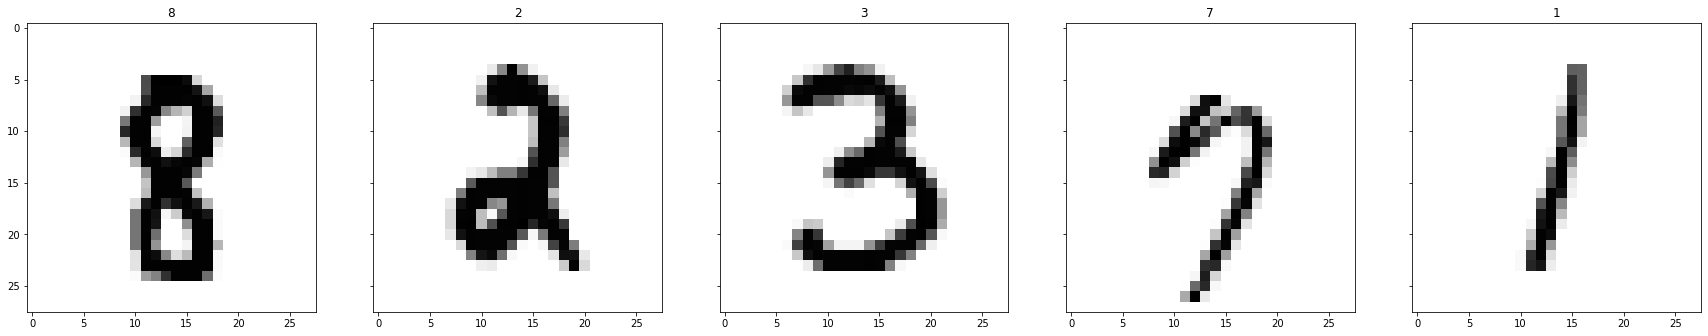

In [6]:
fig, axs = plt.subplots(1, 5, sharey=True)
for i, idx in enumerate(np.random.choice(np.arange(len(training_data)), 5, replace=False)):
    axs[i].imshow(training_data[idx][0][0], cmap="Greys")
    axs[i].set_title(classes[training_data[idx][1]])

We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.



In [7]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


--------------




Creating Models
------------------
To define a neural network in PyTorch, we create a class that inherits
from `nn.Module`. We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU if available.



In [8]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 3, 3),
            nn.ReLU(),                      
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(507, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
model

Using cuda device


NeuralNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=507, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)

--------------




Optimizing the Model Parameters
----------------------------------------
To train a model, we need a loss function
and an optimizer.



In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.



In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model's performance against the test dataset to ensure it is learning.



In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



In [12]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.309376  [    0/60000]
loss: 0.441752  [ 6400/60000]
loss: 0.343133  [12800/60000]
loss: 0.251783  [19200/60000]
loss: 0.112606  [25600/60000]
loss: 0.269345  [32000/60000]
loss: 0.172561  [38400/60000]
loss: 0.274205  [44800/60000]
loss: 0.321674  [51200/60000]
loss: 0.245156  [57600/60000]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.135453 

Epoch 2
-------------------------------
loss: 0.153683  [    0/60000]
loss: 0.147820  [ 6400/60000]
loss: 0.127423  [12800/60000]
loss: 0.131802  [19200/60000]
loss: 0.035190  [25600/60000]
loss: 0.152132  [32000/60000]
loss: 0.108148  [38400/60000]
loss: 0.171430  [44800/60000]
loss: 0.237253  [51200/60000]
loss: 0.166155  [57600/60000]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.086247 

Done!


--------------




Saving Models
-------------
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).



In [13]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Loading Models
----------------------------

The process for loading a model includes re-creating the model structure and loading
the state dictionary into it.



In [14]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

This model can now be used to make predictions.



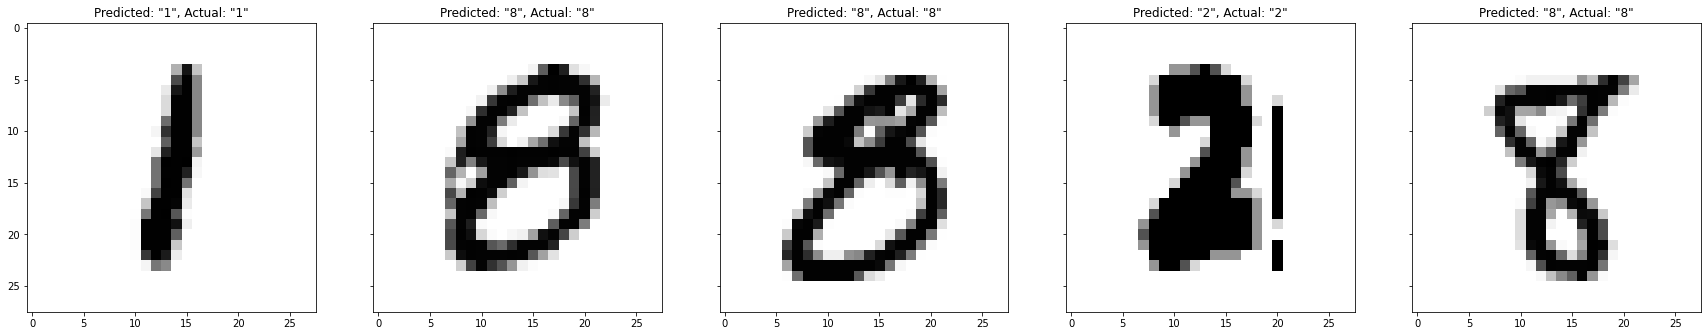

In [15]:
model.eval()
with torch.no_grad():
    fig, axs = plt.subplots(1, 5, sharey=True)
    for i, idx in enumerate(np.random.choice(np.arange(len(test_data)), 5, replace=False)):
        x, y = test_data[idx]
        axs[i].imshow(x[0], cmap="Greys")
        pred = model(torch.unsqueeze(x, 0))
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        axs[i].set_title(f'Predicted: "{predicted}", Actual: "{actual}"')